In [4]:
# Importando as bibliotecas necessárias
import pandas as pd
import os
import kagglehub
import shutil
import requests
import gzip
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer

In [5]:
# 1. Carregar os Dados
IMDB = '../data/'
df = pd.read_csv(IMDB + 'filmes_series_imdb.csv')

# --- DEFINIR X E Y ---
colunas_features = ['release_year', 'run_time_minutes', 'number_votes'] + \
                   [c for c in df.columns if c.startswith('Genre_')] + \
                   [c for c in df.columns if c.startswith('type_')] + \
                   [c for c in df.columns if c.startswith('streaming_')]

X = df[colunas_features]
y = df['target'] 

# --- TREINO ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

previsoes = modelo.predict(X_test)

# --- AVALIAÇÃO ---
rmse = np.sqrt(mean_squared_error(y_test, previsoes))
r2 = r2_score(y_test, previsoes)

print(f"--- Resultados (Prevendo Classe 0-4) ---")
print(f"RMSE (Erro Médio): {rmse:.2f}")
print(f"R²: {r2:.2f}")

# --- TABELA COMPARATIVA ---
tabela = pd.DataFrame({
    'Título': df.loc[y_test.index, 'title'],
    'Classe Real': y_test,
    'Previsão (Numérica)': previsoes.round(2),
    'Previsão (Arredondada)': previsoes.round(0).astype(int),
    'Erro': (y_test - previsoes).round(2)
})
tabela['Erro Absoluto'] = tabela['Erro'].abs()

print("\n--- Onde o Modelo Acertou em Cheio ---")
print(tabela.sort_values(by='Erro Absoluto').head(5))

print("\n--- Onde o Modelo Mais Errou ---")
print(tabela.sort_values(by='Erro Absoluto', ascending=False).head(5))

--- Resultados (Prevendo Classe 0-4) ---
RMSE (Erro Médio): 0.60
R²: 0.22

--- Onde o Modelo Acertou em Cheio ---
                                     Título  Classe Real  Previsão (Numérica)  \
180                  Ghost of the Mountains            3                  3.0   
1983                         Jacob's Hammer            2                  2.0   
12004                                   Mud            3                  3.0   
5657                      An Egyptian Story            3                  3.0   
4850   Casablancas: The Man Who Loved Women            3                  3.0   

       Previsão (Arredondada)  Erro  Erro Absoluto  
180                         3  -0.0            0.0  
1983                        2   0.0            0.0  
12004                       3   0.0            0.0  
5657                        3  -0.0            0.0  
4850                        3  -0.0            0.0  

--- Onde o Modelo Mais Errou ---
                               Título  Classe R

<Figure size 1000x800 with 0 Axes>

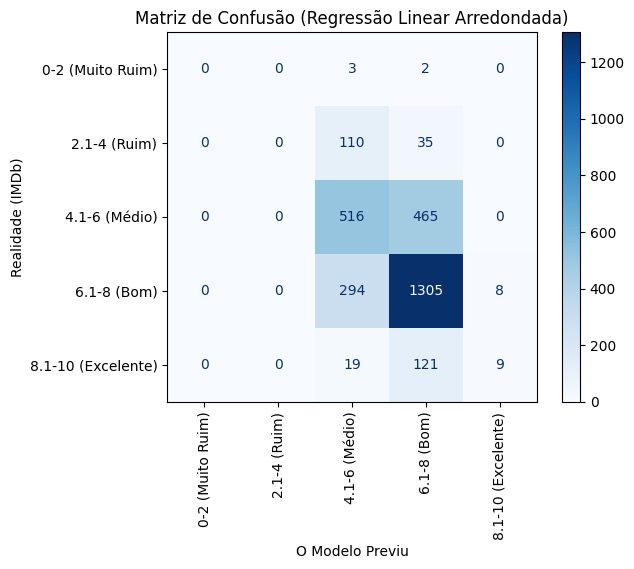

In [6]:
# --- 1. Converter Previsão Numérica (Regressão) para Classe (Classificação) ---
# Arredonda para o inteiro mais próximo (ex: 2.6 -> 3)
y_pred_classes = np.round(previsoes)

# Garante que não existam números fora do limite (menor que 0 ou maior que 4)
# Caso o modelo preveja -0.5 (vira 0) ou 5.2 (vira 4)
y_pred_classes = np.clip(y_pred_classes, 0, 4).astype(int)

# --- 2. Gerar a Matriz de Confusão ---
cm = confusion_matrix(y_test, y_pred_classes)

# --- 3. Visualizar ---
# Definindo os nomes das classes para ficar fácil de ler no gráfico
nomes_classes = ['0-2 (Muito Ruim)', '2.1-4 (Ruim)', '4.1-6 (Médio)', '6.1-8 (Bom)', '8.1-10 (Excelente)']

# Plotar
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nomes_classes)
disp.plot(cmap='Blues', values_format='d', xticks_rotation='vertical')

plt.title('Matriz de Confusão (Regressão Linear Arredondada)')
plt.xlabel('O Modelo Previu')
plt.ylabel('Realidade (IMDb)')
plt.show()